In [ ]:
from sctoolbox.utils.jupyter import bgcolor, _compare_version
import warnings
warnings.filterwarnings("ignore")

# change the background of input cells
bgcolor("PowderBlue", select=[2, 4, 7])

nb_name = "pseudotime_analysis.ipynb"

_compare_version(nb_name)

# Trajectory and Pseudotime Analysis
<hr style="border:2px solid black"> </hr>

## 1 - Description

**Requires a clustered or otherwise categorized anndata object. A clustering can be generated with a clustering notebook (e.g. `rna_analysis/notebooks/04_clustering.ipynb`).**

**Move this notebook into the notebook folder (e.g. `rna_analysis/notebooks/`) of the respective analysis before using it!**

### 1.1 - Pseudotime Analysis
For pseudotime ordering (or trajectory interference) cells are ordered along a continuous path based on their difference in gene expression. This differs from the velocity analysis which uses the rate of unspliced and spliced mRNAs.  
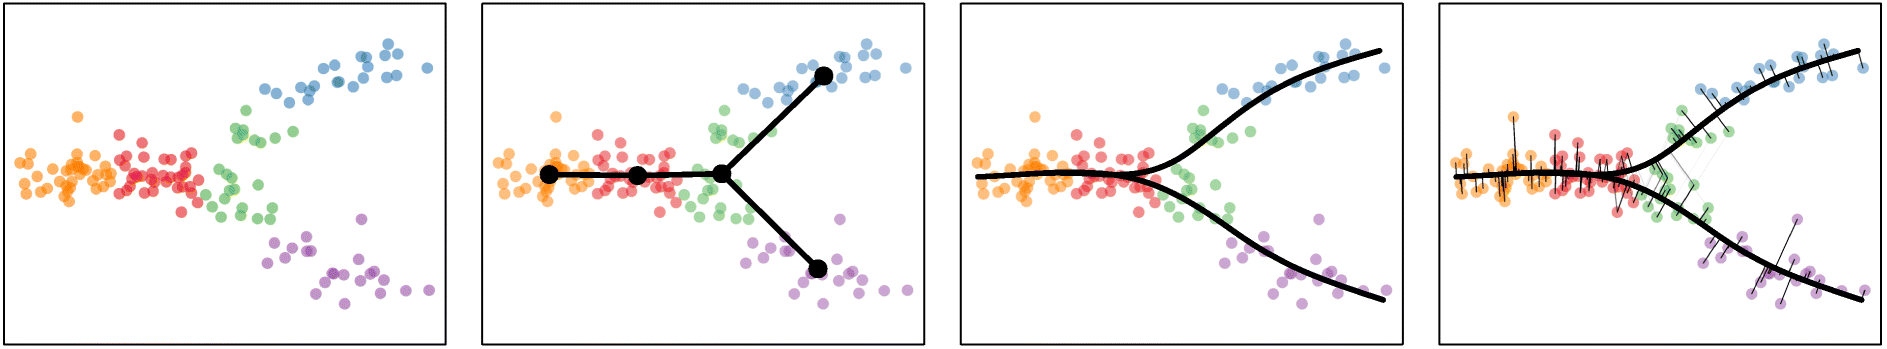
<span style="color:lightgrey">Image source: https://en.wikipedia.org/wiki/Trajectory_inference</span>.

This notebook can be used for trajectory analysis of scRNA data using the scFates package.  
Most analysis steps are directly taken from the scFates <a href=https://scfates.readthedocs.io/en/latest/Tree_Analysis_Bone_marrow_fates.html>documentation</a>

### 1.2 - Parameters
| Parameter | Description | Options |
|:---:|:---|:---|
| `graph` | Type of the principal graph, `curve` for a basic linear curve or `tree` for a more complex trajectory.| `curve`,  `tree`|
| `nodes` | Number of nodes composing the principial tree, use a range of `10` to `100` for ElPiGraph approach and `100` to `2000` for the PPT approach.| int |
| `ndims_rep` | Number of dimensions to use for the inference.| int |
| `method` | Principal graph algorithm for **tree** inference. `method='curve' ` will always use `epg`.| `ppt`, `epg` |
| `ppt_sigma` | Regularization parameter for the simpleppt (`method='ppt'`) algorithm.| float, int |
| `ppt_lambda` | Penalty for the tree length.| float, int |
| `epg_lambda` | Parameter for the ElPiGraph, coefficient of ‘stretching’ elasticity.| float, int |
| `epg_mu` | Parameter for ElPiGraph, coefficient of ‘bending’ elasticity.| float, int |
| `n_map` | The number of probabilistic mapping of the cells onto the tree to use. If `n_map=1` the then likelihood cell mapping is used.| int |
| `n_threads` | The number of cpu processes to use in case of performing multiple mapping.| int |

___

## 2 - Setup

In [ ]:
import scanpy as sc
import pandas as pd
import sctoolbox.utils as utils
import sctoolbox.plotting as pl
from sctoolbox import settings
import matplotlib.pyplot as plt
from pathlib import Path

## scFates
import scFates as scf

sc.set_figure_params(vector_friendly=True, dpi_save=300, scanpy=False)

settings.settings_from_config("config.yaml", key="pseudotime_analysis")

with pd.option_context("display.max.rows", None, "display.max_colwidth", None):
    display(utils.general.get_version_report(report="versions.yml"))

___

## 3 - Input/output settings

In [ ]:
# Input/Output
last_notebook_adata = "anndata_4.h5ad"
output = "anndata_pseudotime.h5ad"

___

## 4 - Load anndata

In [ ]:
adata = utils.adata.load_h5ad(last_notebook_adata)

with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata)
    display(adata.obs)
    display(adata.var)

___

## 5 - scFates
<hr style="border:2px solid black"> </hr>

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [ ]:
### scFates parameters ###
seed = 1

# Column containing final clustering
clustering = "clustering"
# Embedding pca/umap/tsne...
embedding = "umap"
graph = "tree"  # can be "curve" for a basic linear curve or "tree" for a more complex trajectory
nodes = 100  # number of nodes for the principal graph, if None, number of nodes will be automatically inferred based on the number of cells
             # use a range of 10 to 100 for ElPiGraph (epg) approach and 100 to 2000 for PPT approach
ndims_rep = 2  # Number of dimensions to use for the inference
method = "ppt"  # principal graph algorithm for tree inference, "ppt" or "epg"
## PPT ##
# used if graph='tree' and method='ppt'
ppt_sigma = None  # Regularization parameter for simpleppt (method='ppt') algorithm, if None, it will be inferred automatically
ppt_lambda = 100  # Parameter for simpleppt (method='ppt'), penalty for the tree length 
## EPG ##
# used if graph='curve' or method='epg'
epg_lambda=0.01  # coefficient of ‘stretching’ elasticity
epg_mu=0.1  # coefficient of ‘bending’ elasticity

n_map = 10  # number of probabilistic mapping of cells onto the tree to use. If n_map=1 then likelihood cell mapping is used
n_threads = 4

----------

### 5.1 - Calculate Graph

In [ ]:
if nodes is None:
    if adata.shape[0] * 2 > 100:
        nodes = 100
    else:
        nodes = int(adata.shape[0] / 2)

if graph == 'curve':
    scf.tl.curve(adata,
                 Nodes=nodes,
                 use_rep=f"X_{embedding}",
                 ndims_rep=ndims_rep,
                 epg_lambda=epg_lambda,
                 epg_mu=epg_mu,
                 seed=seed)

elif graph == 'tree':
    if method == 'ppt':
        if ppt_sigma is None:
            ppt_sigma = scf.tl.explore_sigma(adata,
                                             Nodes=nodes,
                                             use_rep=embedding,
                                             sigmas=[1000, 100, 10, 1, 0.1, 0.025, 0.01],
                                             plot=False, second_round=True)

            print(f"Sigma value for 'ppt' is None! Automatic value is calculated: simga = {ppt_sigma}")

    print(f"Algorithm used: {method}\n")
    scf.tl.tree(adata,
                method=method,
                Nodes=nodes,
                use_rep=embedding,
                ppt_lambda=ppt_lambda,
                ppt_sigma=ppt_sigma,
                ppt_nsteps=50,
                epg_lambda=epg_lambda,
                epg_mu=epg_mu,
                seed=seed)

----------

### 5.2 - Plot graph
Generates a principal graph inferred from the embedding. Cells are assigned to a node by a value between 0 and 1, which allows the use of probabilistic mappings to account for variability. In case of the clustering showing cell types this can be interpreted as potential differentiation paths a cell could take. However, they are not yet in a pseudotime context so there is no direction in the presented graph.

In [ ]:
scf.pl.graph(adata, basis=embedding, color_cells=clustering, alpha=0.2, show=False)
pl.general._save_figure(f"trajectory_{graph}_{embedding}.pdf")
# Plot graph to automated report directory, no visible output
pl.general._save_figure(f"01_trajectory.png", report=True)

----------

### 5.3 - Pseudotime

#### Note!
The pseudotime analysis requires a starting point (root), considered as the earliest time point. Thus, you need to specify a root node to proceed. Using this node, the pseudotime will be calculated as the distance of each node to the root node.

**Choose a root node in the marked cell below.** There are three options on what the root node could be:
    
1. Select a node by ID. By observing the graph above a suitable node can be picked by choosing one of the displayed node IDs.
2. Select a gene as root. Provide a gene of interest, where the highest expression will be considered root.
3. Automatic node detection based on a cell (`.obs`) measurement. Select a `.obs` column by name that contains numeric values e.g. the expression of a specific gene or a set of genes.

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [ ]:
# choose a root for the pseudotime analysis; The root can either be:
# -> Node ID from the graph above (int)
# -> Gene name to derive pseudotime based on it's expression (str)
# You can also use a column in .obs with continuous values to calculate pseudotime based on these values (str)
# Example: root = 1, root = 'gene name', root = 'obs_column'
root = 0

----------

In [ ]:
if type(root) not in [str, int]:
    raise TypeError("Invalid root! please provide either a node ID (int), gene name (str) or .obs columns (str)")
if type(root) == str:
    if root not in adata.obs.columns and root not in adata.var_names:
        raise ValueError("String was not found in adata.obs or adata.var! Please provide a valid obs column or gene name")
    if root in adata.obs.columns:
        if adata.obs[root].dtypes not in ["float32", "float64", "int32", "int64"]:
            raise TypeError("Given .obs column should contain continuous values! Please provide a valid column")

In [ ]:
scf.tl.root(adata, root=root)

with open(Path(settings.report_dir) / '01_root_selection.md', 'w') as f:
    f.write(f"Selected {'node ' if isinstance(root, int) else ''}**{root}** as pseudotime start.")

try:
    scf.tl.pseudotime(adata, n_jobs=n_threads, n_map=n_map, seed=seed)
except ValueError:
    # sometimes multiple mapping result in some unmapped cells, this could be caused by poor quality
    # of the calculated graph due to poor parameter choice!
    print("Number of cell mapping will be reduced to 1! Consider modifiying and re-running the graph calculation to get more robust results\n")
    scf.tl.pseudotime(adata, n_jobs=1, n_map=1, seed=seed)

if not isinstance(root, int):
    pl.embedding.plot_embedding(adata, color=root, report="01_non_node_root.png")

----------

### 5.4 - Plot Trajectory graph

Same as the plot above but colors the graph based on the pseudotime.
- Darker colors = closer to root (start timepoint)
- Lighter colors = further to root (end timepoint)

In [ ]:
scf.pl.trajectory(adata, basis=embedding, scale_path=0.25, color_cells=clustering,
                  alpha=0.2, arrows=True, show=False)
pl.general._save_figure(f"pseudotime_trajectory_{embedding}.pdf")
# generate pseudotime embedding for report folder
pl.general._save_figure(f"02_pseudotime_trajectory_{embedding}.png", report=True)

----------

In [ ]:
# fix for "zip" error on wrong number of colors in adata.uns["seg_colors"] calculated by scf.tl.pseudotime compared to number of seg entries
if len(adata.uns['seg_colors']) != len(adata.obs['seg'].cat.categories):
    # shorten list of colors to right value
    adata.uns['seg_colors'] = adata.uns['seg_colors'][:len(adata.obs['seg'].cat.categories)]

### 5.5 - Plot pseudotime
- __milestones__: Milestones are the nodes of the trajectory tree. Each milestone represents a key point or “state” during the differentiation process.
 __seg__: Segments are edges (or branches) in the trajectory tree or graph. Each segment represents a developmental transition between two milestones (nodes), corresponding to cells that are transitioning between states.
- __t__: pseudotime values

In [ ]:
pl.embedding.plot_embedding(adata,
                            method=embedding,
                            color=["seg","milestones", "t", clustering],
                            title=["Segments", "Milestones", "Pseudotime", clustering],
                            ncols=2,
                            show=False
                           )
pl.general._save_figure(f"trajectory_tree_segments_{embedding}.pdf")
# generate umaps for report folder
pl.general._save_figure(f"03_trajectory_tree_segments_{embedding}.png", report=True)

----------

### 5.6 - Plot dendogram

This plots a dendrogram showing the branching of segments along the pseudotime.

In [ ]:
# calculate dendogram
if graph == 'tree':
    scf.tl.dendrogram(adata)
    plt.close()
    scf.pl.dendrogram(adata, color=[clustering], show=False)
    pl.general._save_figure(f"trajectory_tree_{clustering}_dendogram.pdf")
    # generate dendogram for report folder
    pl.general._save_figure(f"04_trajectory_tree_{clustering}_dendogram.png", report=True)

----------

## 6 - Saving adata

In [ ]:
utils.io.update_yaml({"pseudotime": True}, yml="method.yml", path_prefix="report")
utils.adata.save_h5ad(adata, output)

In [ ]:
settings.close_logfile()